In [2]:
import wfdb
import wfdb.processing
from wfdb.processing import xqrs_detect
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.integrate import trapz
%matplotlib inline

# Using the wfdb library to read the data.

(array(['A', 'N'], dtype='<U1'), array([453,  39], dtype=int64))


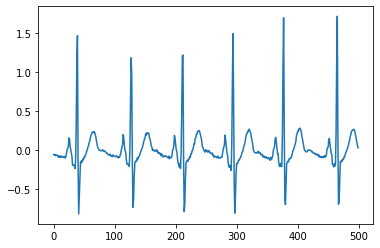

In [3]:
#main path for dataset
path = "../../apnea-ecg-database-1.0.0/"
#read a sample record from dataset
Signal_record = wfdb.rdrecord(os.path.join(path, 'a01'), channels=[0])
outcome = wfdb.rdann(os.path.join(path,'a04'), extension='apn')
print(np.unique(outcome.symbol, return_counts=True))
#plot the start of the signal
plt.plot(Signal_record.p_signal[0:500])
plt.show()

# Time domain features + functions
[Source for features mentioned](https://www.mdpi.com/2076-3417/12/9/4218)

feature | Description
---  | ---
RRmean |	Mean of RR intervals 
RMSSD | Root mean square of differences between adjacent RR intervals 
SDNN | Standard deviation of RR intervals 
NN50 | Number of adjacent RR intervals exceeding 50 milliseconds 
pNN50 |	Ratio of NN50 to the number of RR intervals 
HR	| Mean of heart rates 


## These are secondary functions that are called in time_domain_features() and frequency_domain_features

In [5]:
def calc_RR_intervals(ecg_signal, fs):
    '''
    ecg_signal: time series data
    fs: sample rate
    return: rr_intervals
    the RR interval is the time between two consecutive R peaks, returned in milliseconds
    '''
    qrs_inds = xqrs_detect(ecg_signal, fs=fs)
    # Calculate R-R intervals
    rr_intervals = np.diff(qrs_inds) / fs  # convert to seconds
    return rr_intervals
#calculates the R amplitudes RAMP signal
def calc_RAMP(ecg_sig):
    # linear spaced vector between 0.5 pi and 1.5 pi 
    v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)
    # use sine to approximate QRS feature
    peak_filter = np.sin(v)
    ecg_transformed = np.correlate(ecg_sig, peak_filter, mode="same")
    rr_peaks, _ = signal.find_peaks(ecg_transformed, distance=50)
    return rr_peaks

# Get time domain for one element (1-D)

In [119]:
# returns time domain features for a chunk of signal
def time_domain_features(ecg_signal, fs):
    '''
    ecg_signal: 1-D numpyarray time series ECG
    fs: sample rate
    return: RRmean, mean of RR intervals
            RRMSSD, Root mean square of differences between adjacent RR intervals
            SDNN, standard deviation of RR intervals
            NN50, Number of adjacent RR intervals differing by more than 50 ms
            pNN50, Proportion of NN50 divided by total number of RR intervals
            mean_HR Mean heart rate
    '''
    rr_intervals = calc_RR_intervals(ecg_signal, fs)
    RRmean = np.mean(rr_intervals)
    RRMSSD = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    SDNN = np.std(rr_intervals)
    NN50 = np.sum(np.abs(np.diff(rr_intervals)) > 50)
    pNN50 = NN50 / len(rr_intervals)
    mean_HR = 60 / RRmean
    return RRmean, RRMSSD, SDNN, NN50, pNN50, mean_HR

In [121]:
a, b, c,d,e,f = time_domain_features(Signal_record.p_signal[:,0], Signal_record.fs)
print(a, b, c, d, e, f)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
0.987412244080024 0.1025121170151926 0.1641593585591422 0 0.0 60.764893649766556


# Frequency domain features

    Features | Description
	--- | ---
	VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
	LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
	HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal
	LF/HF1, LF/HF2	| Ratio of LF to HF
	LFnorm1, LFnorm2 |	Normalized low frequency components
	HFnorm1, HFnorm2 |	Normalized high frequency components

Note: 1, 2 represent the frequency domain features of the RR interval and RAMP, respectively.

In [8]:
def frequency_domain(ecg_sig, fs):
    rri = calc_RR_intervals(ecg_sig, fs)
    rr_peaks = calc_RAMP(ecg_sig)
    # Estimate the spectral density using Welch's method
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    # calculate RR features
    fxx_RR, pxx_RR = signal.periodogram(x=rri, fs=fs)
    cond_vlf_RR = (fxx_RR >= 0) & (fxx_RR < 0.04)
    cond_lf_RR = (fxx_RR >= 0.04) & (fxx_RR < 0.15)
    cond_hf_RR = (fxx_RR >= 0.15) & (fxx_RR < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RR = trapz(pxx_RR[cond_vlf_RR], fxx_RR[cond_vlf_RR])
    lf_RR = trapz(pxx_RR[cond_lf_RR], fxx_RR[cond_lf_RR])
    hf_RR = trapz(pxx_RR[cond_hf_RR], fxx_RR[cond_hf_RR])
    # sum these up to get total power
    total_power_RR = vlf_RR + lf_RR + hf_RR
    # find which frequency has the most power in each band
    peak_vlf_RR = fxx_RR[cond_vlf_RR][np.argmax(pxx_RR[cond_vlf_RR])]
    peak_lf_RR = fxx_RR[cond_lf_RR][np.argmax(pxx_RR[cond_lf_RR])]
    peak_hf_RR = fxx_RR[cond_hf_RR][np.argmax(pxx_RR[cond_hf_RR])]
    lf_norm_RR = lf_RR/ total_power_RR
    hf_norm_RR = hf_RR / total_power_RR
    
    #calculate RAMP features
    fxx_RAMP, pxx_RAMP = signal.periodogram(x=rr_peaks, fs=fs)
    cond_vlf_RAMP = (fxx_RAMP >= 0) & (fxx_RAMP < 0.04)
    cond_lf_RAMP = (fxx_RAMP >= 0.04) & (fxx_RAMP < 0.15)
    cond_hf_RAMP = (fxx_RAMP>= 0.15) & (fxx_RAMP < 0.4)
    # calculate power in each band by integrating the spectral density 
    vlf_RAMP = trapz(pxx_RAMP[cond_vlf_RAMP], fxx_RAMP[cond_vlf_RAMP])
    lf_RAMP = trapz(pxx_RAMP[cond_lf_RAMP], fxx_RAMP[cond_lf_RAMP])
    hf_RAMP = trapz(pxx_RAMP[cond_hf_RAMP], fxx_RAMP[cond_hf_RAMP])
    # sum these up to get total power
    total_power_RAMP = vlf_RAMP + lf_RAMP + hf_RAMP
    # find which frequency has the most power in each band
    peak_vlf_RAMP = fxx_RAMP[cond_vlf_RAMP][np.argmax(pxx_RAMP[cond_vlf_RAMP])]
    peak_lf_RAMP = fxx_RAMP[cond_lf_RAMP][np.argmax(pxx_RAMP[cond_lf_RAMP])]
    peak_hf_RAMP = fxx_RAMP[cond_hf_RAMP][np.argmax(pxx_RAMP[cond_hf_RAMP])]
    lf_norm_RAMP = lf_RAMP / total_power_RAMP
    hf_norm_RAMP = hf_RAMP / total_power_RAMP  


    #map values to aforementioned values
    VLF1 = vlf_RR; VLF2 = vlf_RAMP # VLF1, VLF2 | Very low frequency (0-0.04 Hz) component of the corresponding signal
    LF1 = lf_RR; LF2 = lf_RAMP # LF1, LF2 | Low frequency (0.04~0.15 Hz) component of the corresponding signal
    HF1 = hf_RR; HF2 = hf_RAMP # HF1, HF2 | High frequency (0.15~0.4 Hz) component of the corresponding signal

    LF_HF1 = lf_RR/hf_RR; LF_HF2 = lf_RAMP/hf_RAMP # LF/HF1, LF/HF2	| Ratio of LF to HF
    LF_NORM1 = lf_norm_RR; LF_NORM2 = lf_norm_RAMP# LFnorm1, LFnorm2 |	Normalized low frequency components
    HF_NORM1 = hf_norm_RR; HF_NORM2 = hf_norm_RAMP # HFnorm1, HFnorm2 |	Normalized high frequency components
    return  [VLF1, VLF2, LF1, LF2, HF1, HF2, LF_HF1, LF_HF2, LF_NORM1, LF_NORM2, HF_NORM1, HF_NORM2]

results = frequency_domain(Signal_record.p_signal[:,0], Signal_record.fs)
print(results)